In [45]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torch'

In [ ]:
def make_generator_network(
        input_size = 20,
        num_hidden_layers = 1,
        num_hidden_units = 100,
        num_output_units = 784):
    model = nn.Sequential()

    for i in range(num_hidden_layers):
        model.add_module(f'fc_g{i}', nn.Linear(input_size, num_hidden_units))
        model.add_module(f'relu_g{i}', nn.LeakyReLU())

        input_size = num_hidden_units

    model.add_module(f'fc_g{num_hidden_layers}', nn.Linear(input_size, num_output_units))
    model.add_module('tanh_g', nn.Tanh())

    return model

In [ ]:
def make_discriminator_network(
        input_size,
        num_hidden_layers = 1,
        num_hidden_units = 100,
        num_output_units = 1):
    model = nn.Sequential()

    for i in range(num_hidden_layers):
        model.add_module(
            f'fc_d{i}',
            nn.Linear(input_size, num_hidden_units, bias=False)
        )

        model.add_module(f'relu_d{i}', nn.LeakyReLU())
        model.add_module('dropout', nn.Dropout(p=0.5))
        
        input_size = num_hidden_units

    model.add_module(f'fc_d{num_hidden_layers}', nn.Linear(input_size, num_output_units))
    model.add_module('sigmoid', nn.Sigmoid())

    return model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/enfycius/anaconda3/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
image_size = (28, 28)
z_size = 20

gen_hidden_layers = 1
gen_hidden_size = 100

disc_hidden_layers = 1
disc_hidden_size = 100

In [ ]:
torch.manual_seed(1)

In [ ]:
gen_model = make_generator_network(
    input_size = z_size,
    num_hidden_layers = gen_hidden_layers,
    num_hidden_units = gen_hidden_size,
    num_output_units = np.prod(image_size)
)

In [ ]:
print(gen_model)

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)


In [ ]:
disc_model = make_discriminator_network(
    input_size = np.prod(image_size),
    num_hidden_layers = disc_hidden_layers,
    num_hidden_units = disc_hidden_size
)

In [ ]:
print(disc_model)

Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
import torchvision
from torchvision import transforms

/home/enfycius/anaconda3/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


In [ ]:
image_path = './'

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)),
])

In [ ]:
mnist_dataset = torchvision.datasets.MNIST(
    root = image_path, train = True, transform = transform, download=True
)

In [ ]:
example, label = next(iter(mnist_dataset))

In [ ]:
print(f'Min: {example.min()} Max: {example.max()}')

Min: -1.0 Max: 1.0


In [ ]:
print(example.shape)

torch.Size([1, 28, 28])


In [ ]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size) * 2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size)

    return input_z

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
batch_size = 32

In [ ]:
dataloader = DataLoader(mnist_dataset, batch_size, shuffle=False)

In [ ]:
input_real, label = next(iter(dataloader))
input_real = input_real.view(batch_size, -1)

In [ ]:
torch.manual_seed(1)

In [ ]:
mode_z = 'uniform'

In [ ]:
input_z = create_noise(batch_size, z_size, mode_z)

In [ ]:
print('input-z -- shape:', input_z.shape)
print('input-real -- shape:', input_real.shape)

input-z -- shape: torch.Size([32, 20])
input-real -- shape: torch.Size([32, 784])


In [ ]:
g_output = gen_model(input_z)

In [ ]:
print('Output of G -- shape:', g_output.shape)

Output of G -- shape: torch.Size([32, 784])


In [ ]:
d_proba_real = disc_model(input_real)

In [ ]:
d_proba_fake = disc_model(g_output)

In [ ]:
print('Disc. (real) -- shape:', d_proba_real.shape)
print('Disc. (fake) -- shape:', d_proba_fake.shape)

Disc. (real) -- shape: torch.Size([32, 1])
Disc. (fake) -- shape: torch.Size([32, 1])


In [ ]:
loss_fn = nn.BCELoss()

In [ ]:
g_labels_real = torch.ones_like(d_proba_fake)
g_loss = loss_fn(d_proba_fake, g_labels_real)

In [ ]:
print(f'Generator Loss: {g_loss: .4f}')

Generator Loss:  0.6983


In [ ]:
d_labels_real = torch.ones_like(d_proba_real)
d_labels_fake = torch.zeros_like(d_proba_fake)

In [ ]:
d_loss_real = loss_fn(d_proba_real, d_labels_real)
d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

In [ ]:
print(f'Discriminator Losses: Real {d_loss_real: .4f} Fake {d_loss_fake: .4f}')

Discriminator Losses: Real  0.7479 Fake  0.6885


In [ ]:
batch_size = 64
torch.manual_seed(1)
np.random.seed(1)

In [ ]:
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
gen_model = make_generator_network(
    input_size = z_size,
    num_hidden_layers = gen_hidden_layers,
    num_hidden_units = gen_hidden_size,
    num_output_units = np.prod(image_size)
).to(device)

In [ ]:
disc_model = make_discriminator_network(
    input_size = np.prod(image_size),
    num_hidden_layers = disc_hidden_layers,
    num_hidden_units = disc_hidden_size
).to(device)

In [ ]:
loss_fn = nn.BCELoss()

In [ ]:
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

In [ ]:
def d_train(x):
    disc_model.zero_grad()
    batch_size = x.size(0)
    x = x.view(batch_size, -1).to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)
    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [ ]:
def g_train(x):
    gen_model.zero_grad()
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [ ]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

In [ ]:
def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))

    return (images + 1) / 2.0

In [ ]:
epoch_samples = []
all_d_losses = []
all_g_losses = []
all_d_real = []
all_d_fake = []

In [ ]:
num_epochs = 100

In [ ]:
for epoch in range(1, num_epochs + 1):
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []

    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))
        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())

    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())

    print(f'Epoch {epoch: 03d} | Avg Losses >>'
          f' G/D {all_g_losses[-1]: .4f} / {all_d_losses[-1]: .4f}'
          f' [D-Real: {all_d_real[-1]: .4f}]'
          f' D-Fake: {all_d_fake[-1]: .4f}]')
    
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy()
    )

Epoch  01 | Avg Losses >> G/D  0.8728 /  0.9571 [D-Real:  0.7781] D-Fake:  0.4792]
Epoch  02 | Avg Losses >> G/D  0.9060 /  1.1987 [D-Real:  0.5825] D-Fake:  0.4424]
Epoch  03 | Avg Losses >> G/D  0.9141 /  1.1915 [D-Real:  0.5828] D-Fake:  0.4296]
Epoch  04 | Avg Losses >> G/D  0.9876 /  1.2267 [D-Real:  0.5717] D-Fake:  0.4303]
Epoch  05 | Avg Losses >> G/D  0.9362 /  1.2034 [D-Real:  0.5812] D-Fake:  0.4239]
Epoch  06 | Avg Losses >> G/D  1.0746 /  1.1508 [D-Real:  0.5987] D-Fake:  0.3970]
Epoch  07 | Avg Losses >> G/D  1.0302 /  1.1605 [D-Real:  0.5990] D-Fake:  0.4020]
Epoch  08 | Avg Losses >> G/D  0.9962 /  1.1852 [D-Real:  0.5905] D-Fake:  0.4142]
Epoch  09 | Avg Losses >> G/D  0.9970 /  1.1803 [D-Real:  0.5919] D-Fake:  0.4119]
Epoch  10 | Avg Losses >> G/D  0.9573 /  1.1988 [D-Real:  0.5866] D-Fake:  0.4185]
Epoch  11 | Avg Losses >> G/D  0.9965 /  1.1855 [D-Real:  0.5898] D-Fake:  0.4100]
Epoch  12 | Avg Losses >> G/D  1.0099 /  1.1832 [D-Real:  0.5929] D-Fake:  0.4092]
Epoc

In [ ]:
import itertools

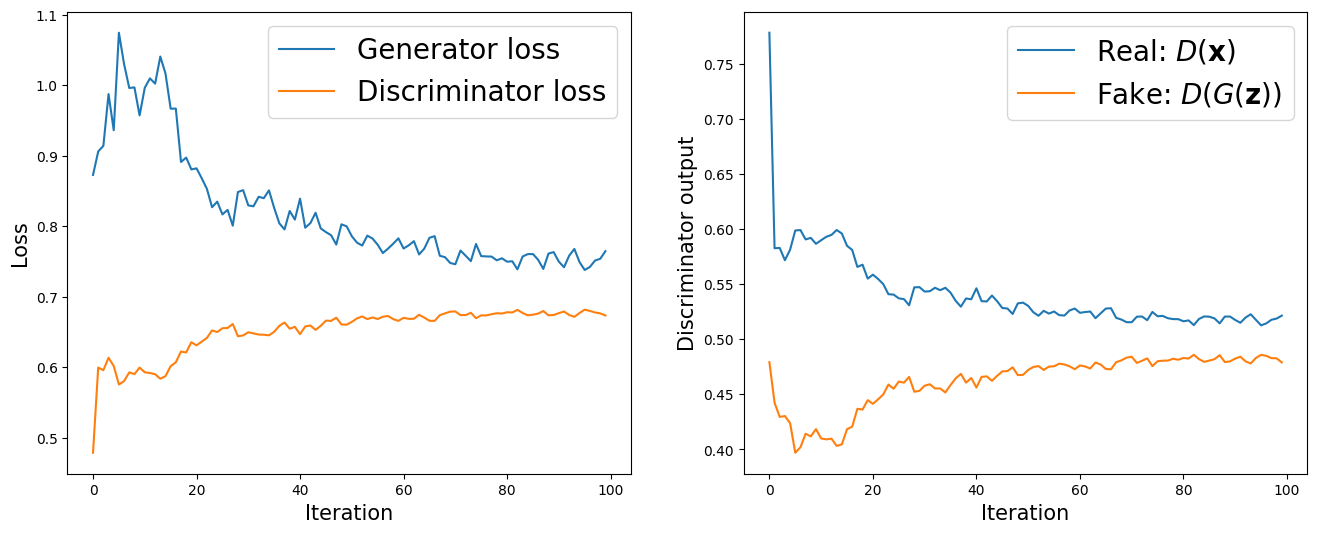

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 2, 1)
plt.plot(all_g_losses, label='Generator loss')

half_d_losses = [all_d_loss / 2 for all_d_loss in all_d_losses]

plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)

ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)

ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

plt.show()

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 100]

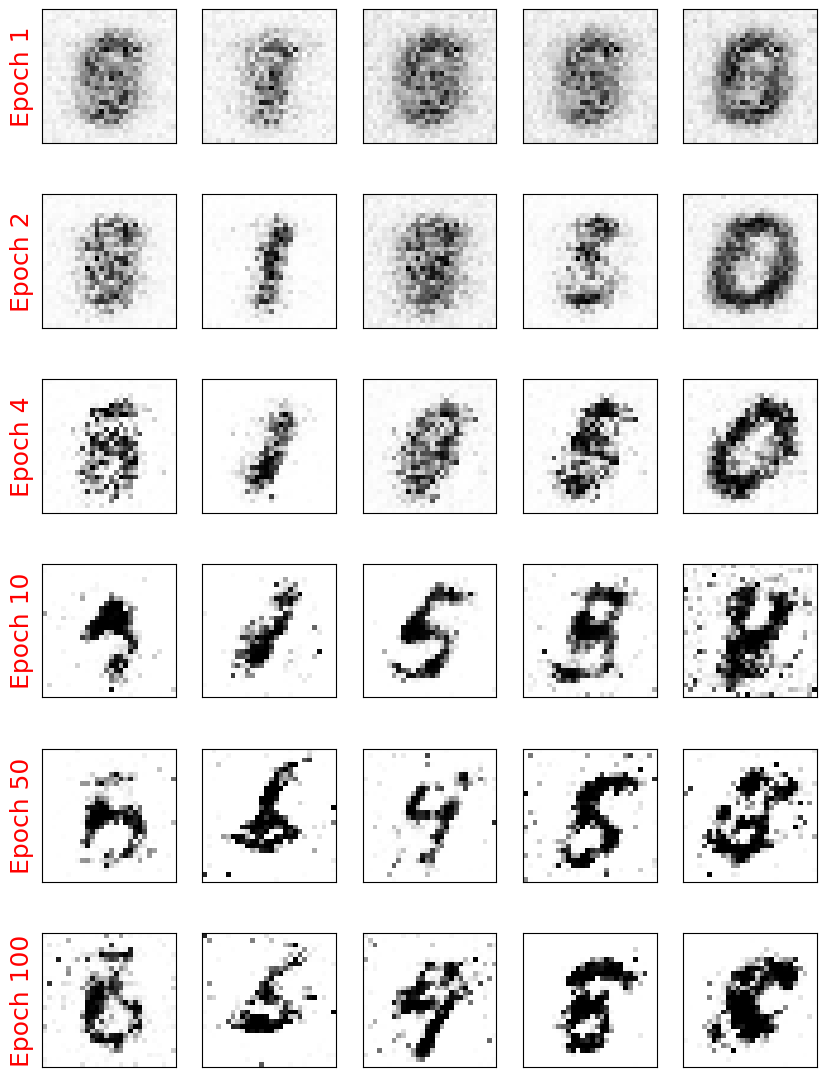

In [ ]:
fig = plt.figure(figsize=(10, 14))

for i, e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i * 5 + j + 1)
        
        ax.set_xticks([])
        ax.set_yticks([])

        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes
            )

        image = epoch_samples[e - 1][j]
        ax.imshow(image, cmap='gray_r')

plt.show()

In [ ]:
def make_generator_network(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters * 4, 4, 1, 0, bias=False),
        nn.BatchNorm2d(n_filters * 4),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters * 4, n_filters * 2, 3, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters * 2),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters * 2, n_filters, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh()
    )

    return model

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters, n_filters * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters * 2, n_filters * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.network(input)

        return output.view(-1, 1).squeeze(0)


In [ ]:
z_size = 100
image_size = (28, 28)
n_filters = 32

In [ ]:
gen_model = make_generator_network(z_size, n_filters).to(device)

In [ ]:
print(gen_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)


In [ ]:
disc_model = Discriminator(n_filters).to(device)

In [ ]:
print(disc_model)

Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [ ]:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [ ]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1) * 2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)

    return input_z

In [ ]:
def d_train(x):
    disc_model.zero_grad()
    batch_size = x.size(0)
    x = x.to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)
    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [ ]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

In [ ]:
epoch_samples = []

In [ ]:
torch.manual_seed(1)

In [ ]:
for epoch in range(1, num_epochs + 1):
    gen_model.train()

    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))

    print(f'Epoch {epoch: 03d} | Avg Losses >>'
          f' G/D {torch.FloatTensor(g_losses).mean():.4f}'
          f'/{torch.FloatTensor(d_losses).mean():.4f}')
    
    gen_model.eval()

    epoch_samples.append(
        create_samples(
            gen_model, fixed_z
        ).detach().cpu().numpy()
    )

Epoch  01 | Avg Losses >> G/D 1.4439/1.0047
Epoch  02 | Avg Losses >> G/D 1.9215/0.8170
Epoch  03 | Avg Losses >> G/D 2.1006/0.7316
Epoch  04 | Avg Losses >> G/D 2.1371/0.6892
Epoch  05 | Avg Losses >> G/D 2.1548/0.6613
Epoch  06 | Avg Losses >> G/D 2.1864/0.6327
Epoch  07 | Avg Losses >> G/D 2.2273/0.6050
Epoch  08 | Avg Losses >> G/D 2.2674/0.5817
Epoch  09 | Avg Losses >> G/D 2.3033/0.5615
Epoch  10 | Avg Losses >> G/D 2.3376/0.5444
Epoch  11 | Avg Losses >> G/D 2.3731/0.5274
Epoch  12 | Avg Losses >> G/D 2.4105/0.5117
Epoch  13 | Avg Losses >> G/D 2.4460/0.4970
Epoch  14 | Avg Losses >> G/D 2.4842/0.4826
Epoch  15 | Avg Losses >> G/D 2.5251/0.4697
Epoch  16 | Avg Losses >> G/D 2.5668/0.4568
Epoch  17 | Avg Losses >> G/D 2.6065/0.4453
Epoch  18 | Avg Losses >> G/D 2.6464/0.4340
Epoch  19 | Avg Losses >> G/D 2.6903/0.4235
Epoch  20 | Avg Losses >> G/D 2.7318/0.4141
Epoch  21 | Avg Losses >> G/D 2.7681/0.4049
Epoch  22 | Avg Losses >> G/D 2.8102/0.3962
Epoch  23 | Avg Losses >> G/D 2.

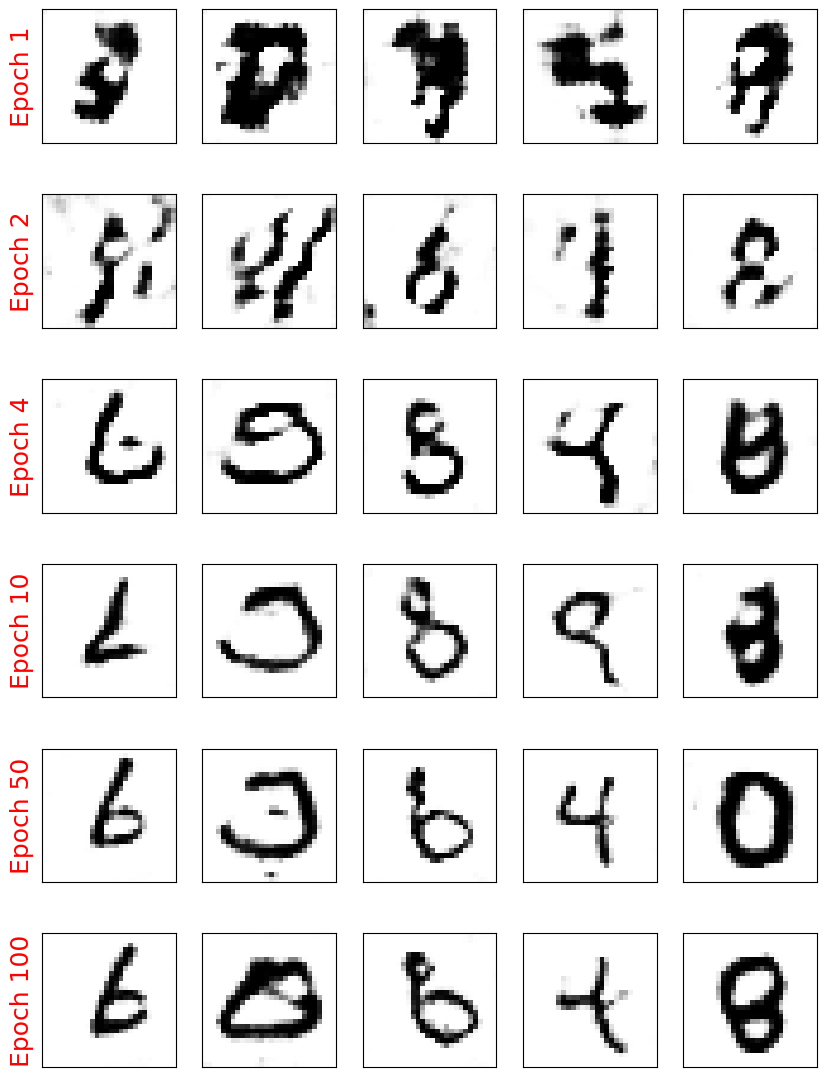

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 100]

fig = plt.figure(figsize=(10, 14))

for i, e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i * 5 + j + 1)
        
        ax.set_xticks([])
        ax.set_yticks([])

        if j == 0:
            ax.text(-0.06, 0.5, f'Epoch {e}',
                    rotation=90, size=18, color='red',
                    horizontalalignment='right',
                    verticalalignment='center',
                    transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]

        ax.imshow(image, cmap='gray_r')

plt.show()